Epoch 1/30


c:\Users\logan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2035/2035 ━━━━━━━━━━━━━━━━━━━━ 2s 769us/step - loss: 0.7018 - val_loss: 0.5215
Epoch 2/30
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - loss: 0.4731 - val_loss: 0.3707
Epoch 3/30
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - loss: 0.3428 - val_loss: 0.2819
Epoch 4/30
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 2s 731us/step - loss: 0.2647 - val_loss: 0.2295
Epoch 5/30
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 2s 735us/step - loss: 0.2198 - val_loss: 0.1986
Epoch 6/30
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 0.1916 - val_loss: 0.1803
Epoch 7/30
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - loss: 0.1763 - val_loss: 0.1695
Epoch 8/30
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - loss: 0.1674 - val_loss: 0.1632
Epoch 9/30
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - loss: 0.1620 - val_loss: 0.1594
Epoch 10/30
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - loss: 0.1569 - val_loss: 0.1571
Epoch 11/30
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 2s 745us/step - loss: 0.1559 - val_loss: 0.1558
Epoch 12/30
2035/20

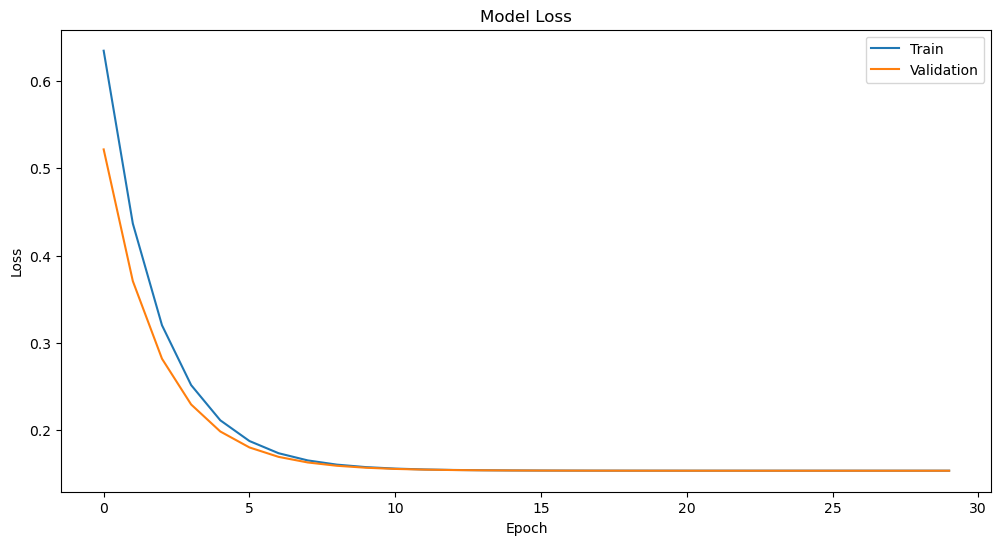

In [46]:
#LOGAN KELSCH
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import SGD

tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------
# 3.0 collected data features:
# Symbol: /ES:XCME
# Work Time: 4/10/23, 3:05 PM - 9/13/24, 1:55 PM
# fulltime- seconds since 1970 (for appending data)
# FullK-    fullK plot for Stochastic of past hour
# diffKD-   value difference between fullK/fullD of past hour
# OB , OS-  boolean if Stoch plots are in top/btm 20% of range
# vol-      trade volume of each bar
# s15,30,60-Current price/time slope of past n minutes 
#ToD-       Time of Day in seconds
#perc30,60- percentile of low and high of past 30,60 mins and day
#RSI-       RSI output of past hour
#Wpercent-  William Percent output of past hour
#acc-       Rate of acceleration of past hour over half hours
################################
#DESIRED OUTPUTS
#Are formulated by making a bull and bear 0-1 oscillator
#standard deviations derived from upcoming 4 hours of movement
#Value description:
#If value==0
#  the conditions are not appealing for next n minutes
#If value==1
#  the price moves >=1 std. dev. in that direciton for next n mins
#else
#  price moves y std. dev. in that direction for next n minutes
#bull/bear15 - 15 minute direction lookahead
#bull/bear30 - 30 minute direction lookahead
#bull/bear60 - 60 minute direction lookahead

# Load the dataset
data = pd.read_csv('ES_5m_4-10-23_to_9-13-24.csv')
#TESTING FIRST FOR 15 MINUTE TRADES

#TEMP DROP PRE 2 OUTPUT NN
#data = data.drop(columns='bull15')
data = data.drop(columns='bear15')

data = data.drop(columns='bull30')
data = data.drop(columns='bear30')

data = data.drop(columns='bull60')
data = data.drop(columns='bear60')

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

#PROCESS THE DATA-------------------------------------------------------

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#BUILD THE NEURAL NETWORK MODEL-------------------------------------------------------

opt = SGD(learning_rate=0.000001)

def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(256, activation='silu'),        
        tf.keras.layers.Dense(1)  # Output layer for regression
    ])
    
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

#TRAIN THE MODEL WITH CUSTOMIZABLE EPOCHS-------------------------------------------------------

epochs = 30

model = build_model(X_train.shape[1])
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, verbose=1)

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

#R and R^2 calculation attempt in the 3 lines below this

#unexplained_error = tf.reduce_sum(tf.square(tf.sub(y, y_pred)))
#total_error = tf.reduce_sum(tf.square(tf.sub(y, tf.reduce_mean(y))))
#R_squared = tf.sub(1, tf.div(unexplained_error, total_error))

#print(f"R^2: {R_squared}")

# ^ need to figure out how to fit a "prediction" variable into first line of this calculation
#or just use a tensorflow_addon rsquared formula to calculate this

#online source suggests that loss < .22 and R^2 over .9 is good
#on a good pace for truly building something here



# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [1]:
# Save the model
model.save('my_model.h5')

# Load the model
loaded_model = tf.keras.models.load_model('my_model.h5')

NameError: name 'model' is not defined